In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import tensorflow as tf

SEED = 1


def set_seed(seed=SEED):
    tf.keras.utils.set_random_seed(seed)


set_seed()
import cv2
import matplotlib.patches as patches
import cv2
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import layers
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet50
from keras.layers import Input, Flatten, Dense, Concatenate, Activation, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

2024-08-03 20:59:58.509362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 20:59:58.509454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 20:59:58.648718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading the dataset

In [2]:
data = pd.read_csv(
    '/kaggle/input/fashion-product-images-small/styles.csv',
    on_bad_lines='skip'
)

data = data.dropna()
data = pd.DataFrame(data)

image_path = '/kaggle/input/fashion-product-images-small/images'

In [3]:
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


# Dataset visualization

In [4]:
def show_k_random(k, name):
    choices = np.random.choice(data.index, k, replace=False)
    choices = data.loc[choices, ['id', name]]
    fig, axs = plt.subplots(1, k, figsize=(15, 10))
    for this_name, id, ax in zip(choices[name], choices['id'], axs.ravel()):
        img_path = f"{image_path}/{id}.jpg"
        img = plt.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{this_name}')
    plt.tight_layout()
    plt.show()

gender


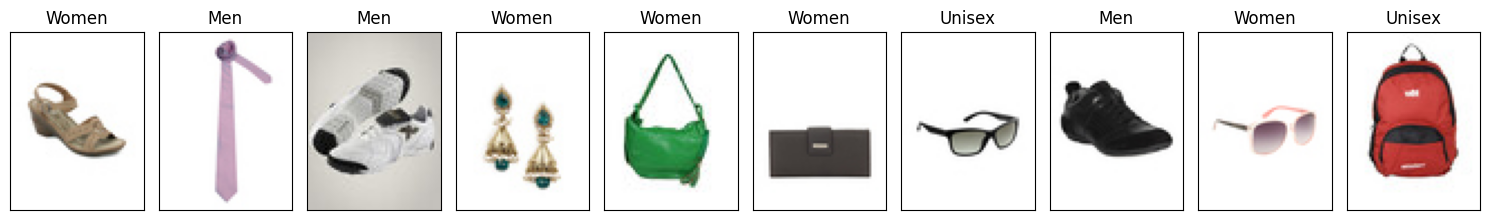

masterCategory


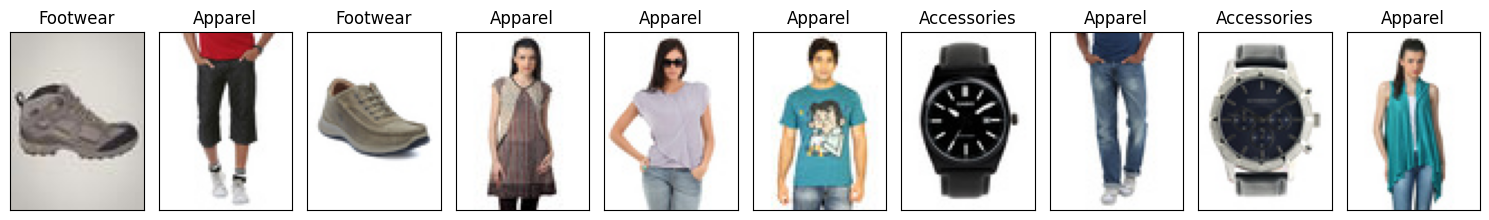

subCategory


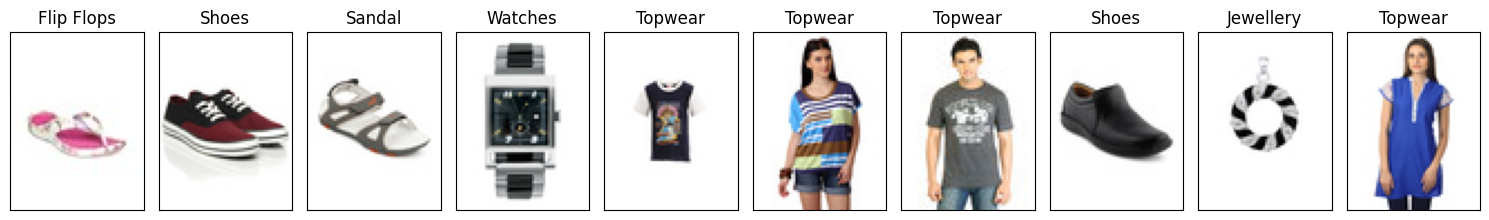

articleType


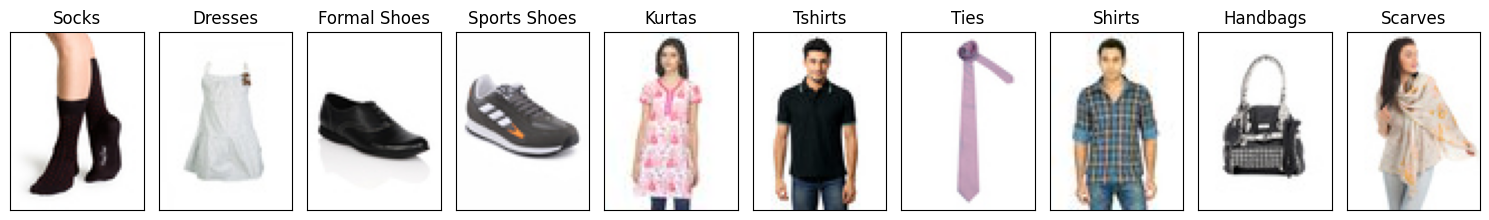

baseColour


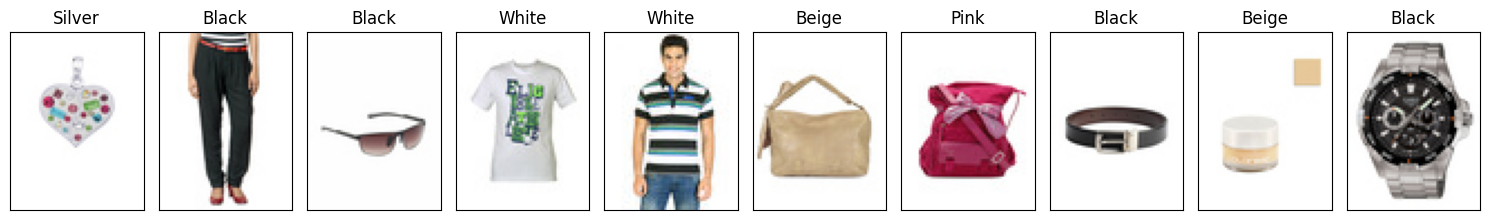

season


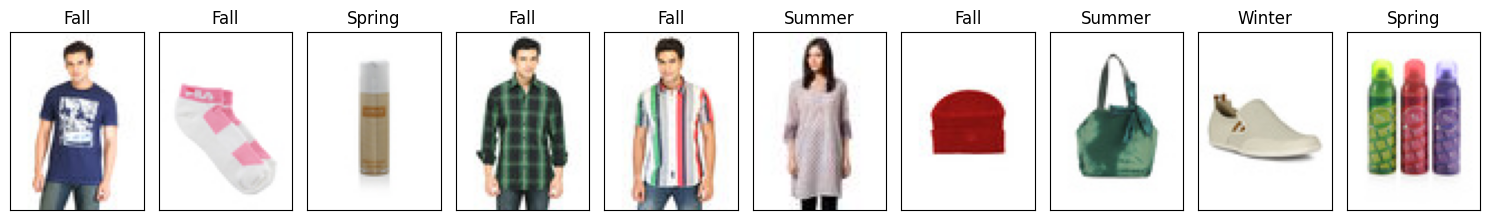

year


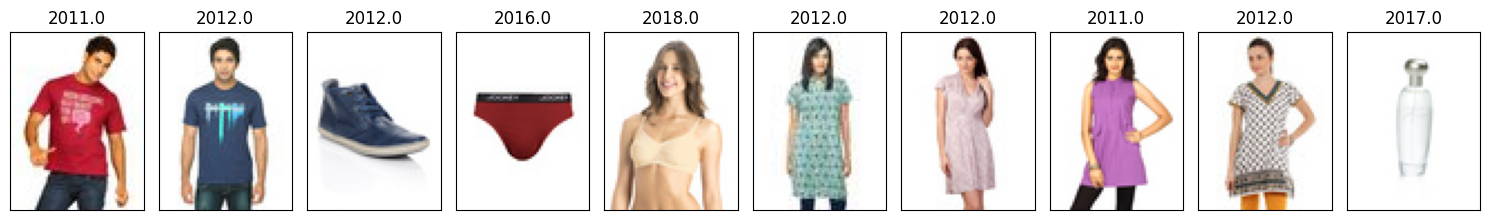

usage


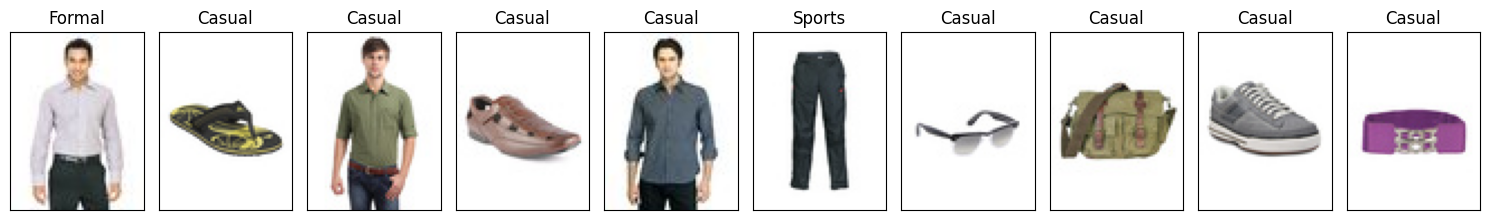

In [6]:
labels = data.columns[1:-1]
for col in labels:
    print(col)
    show_k_random(10, col)

# Extracting labels

In [7]:
new_data = []

if os.path.exists('/kaggle/input/data-labels-fashion-product-images-small/data_labels.csv'):
    print('Loading...')
    new_data = pd.read_csv('/kaggle/input/data-labels-fashion-product-images-small/data_labels.csv')
else:
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        path = f"{image_path}/{row['id']}.jpg"
        if os.path.exists(path):
            new_data.append(get_labels(row))

print(f'Successfully loaded images: {len(new_data)} ({len(new_data) / len(data) * 100}%)')

Loading...
Successfully loaded images: 44072 (99.98865621525967%)


In [8]:
data_labels = pd.DataFrame(new_data)
data_labels.to_csv('data_labels.csv', index=False)
data_labels

,id,path,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,15970,/kaggle/input/fashion-product-images-small/ima...,1,1,1,1,1,1,1,1
1,39386,/kaggle/input/fashion-product-images-small/ima...,1,1,2,2,2,2,2,1
2,59263,/kaggle/input/fashion-product-images-small/ima...,2,2,3,3,3,3,3,1
3,21379,/kaggle/input/fashion-product-images-small/ima...,1,1,2,4,4,1,1,1
4,53759,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,5,2,2,1
...,...,...,...,...,...,...,...,...,...,...
44067,17036,/kaggle/input/fashion-product-images-small/ima...,1,3,5,7,8,2,8,1
44068,6461,/kaggle/input/fashion-product-images-small/ima...,1,3,7,9,17,2,1,1
44069,18842,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,2,1,1,1
44070,46694,/kaggle/input/fashion-product-images-small/ima...,2,4,12,27,2,4,4,1


In [9]:
IMAGE_SIZE = [80, 60]

# Checking Data Distribution

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'masterCategory'}>],
       [<Axes: title={'center': 'subCategory'}>,
        <Axes: title={'center': 'articleType'}>,
        <Axes: title={'center': 'baseColour'}>],
       [<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'usage'}>]], dtype=object)

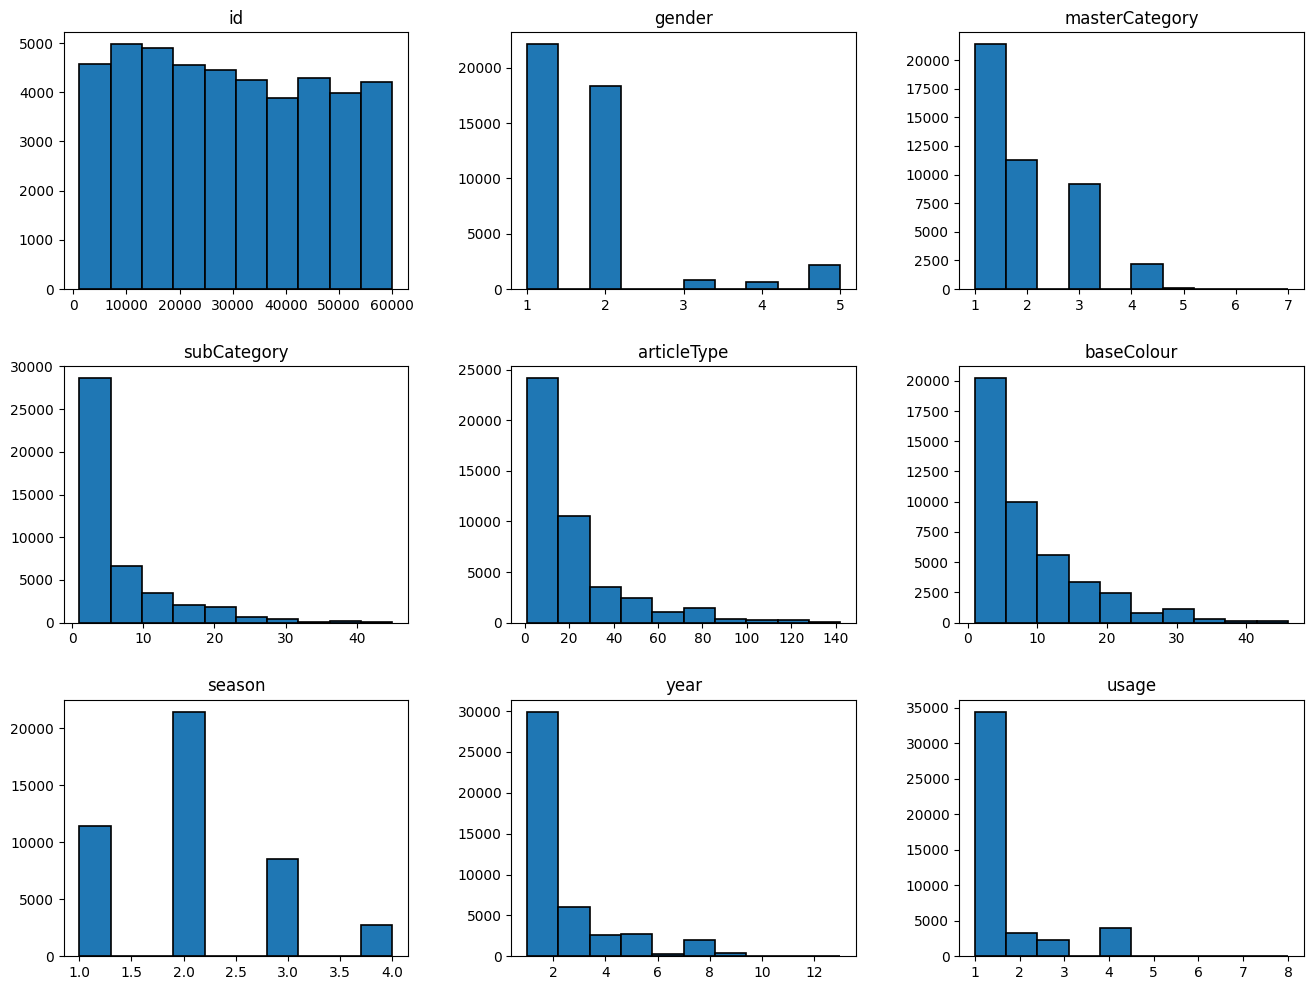

In [10]:
data_labels.hist(figsize=(16, 12), grid=False, edgecolor='black', linewidth=1.2)

In [11]:
color_map = {
    # Neutral Tones
    'Beige': 'Brown',
    'Black': 'Black',
    'Charcoal': 'Gray',
    'Cream': 'White',
    'Grey': 'Gray',
    'Grey Melange': 'Gray',
    'Khaki': 'Brown',
    'Mushroom Brown': 'Brown',
    'Nude': 'Brown',
    'Off White': 'White',
    'Silver': 'Gray',
    'Steel': 'Gray',
    'Tan': 'Brown',
    'Taupe': 'Brown',
    'White': 'White',

    # Red and Pink Tones
    'Burgundy': 'Red',
    'Maroon': 'Red',
    'Mauve': 'Pink',
    'Pink': 'Pink',
    'Rose': 'Pink',
    'Red': 'Red',

    # Orange and Brown Tones
    'Bronze': 'Brown',
    'Brown': 'Brown',
    'Coffee Brown': 'Brown',
    'Copper': 'Brown',
    'Rust': 'Brown',

    # Yellow Tones
    'Gold': 'Yellow',
    'Mustard': 'Yellow',
    'Peach': 'Yellow',
    'Yellow': 'Yellow',

    # Green Tones
    'Fluorescent Green': 'Green',
    'Green': 'Green',
    'Lime Green': 'Green',
    'Olive': 'Green',
    'Sea Green': 'Green',

    # Blue Tones
    'Blue': 'Blue',
    'Navy Blue': 'Blue',
    'Teal': 'Blue',
    'Turquoise Blue': 'Blue',

    # Purple and Violet Tones
    'Lavender': 'Purple',
    'Magenta': 'Purple',
    'Purple': 'Purple',

    # Orange Tones
    'Orange': 'Brown',

    # Unique/Other Colors
    'Metallic': 'Gray',
    'Multi': 'Multi',
    'Skin': 'Yellow',
}

old_colors = zip(data['id'], data['baseColour'])
new_colors = {}
for id, color in old_colors:
    new_colors[id] = color_map[color]

In [12]:
data_labels['baseColour'] = data_labels['id'].map(new_colors)
data_labels

,id,path,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,15970,/kaggle/input/fashion-product-images-small/ima...,1,1,1,1,Blue,1,1,1
1,39386,/kaggle/input/fashion-product-images-small/ima...,1,1,2,2,Blue,2,2,1
2,59263,/kaggle/input/fashion-product-images-small/ima...,2,2,3,3,Gray,3,3,1
3,21379,/kaggle/input/fashion-product-images-small/ima...,1,1,2,4,Black,1,1,1
4,53759,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,Gray,2,2,1
...,...,...,...,...,...,...,...,...,...,...
44067,17036,/kaggle/input/fashion-product-images-small/ima...,1,3,5,7,White,2,8,1
44068,6461,/kaggle/input/fashion-product-images-small/ima...,1,3,7,9,Red,2,1,1
44069,18842,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,Blue,1,1,1
44070,46694,/kaggle/input/fashion-product-images-small/ima...,2,4,12,27,Blue,4,4,1


<Axes: >

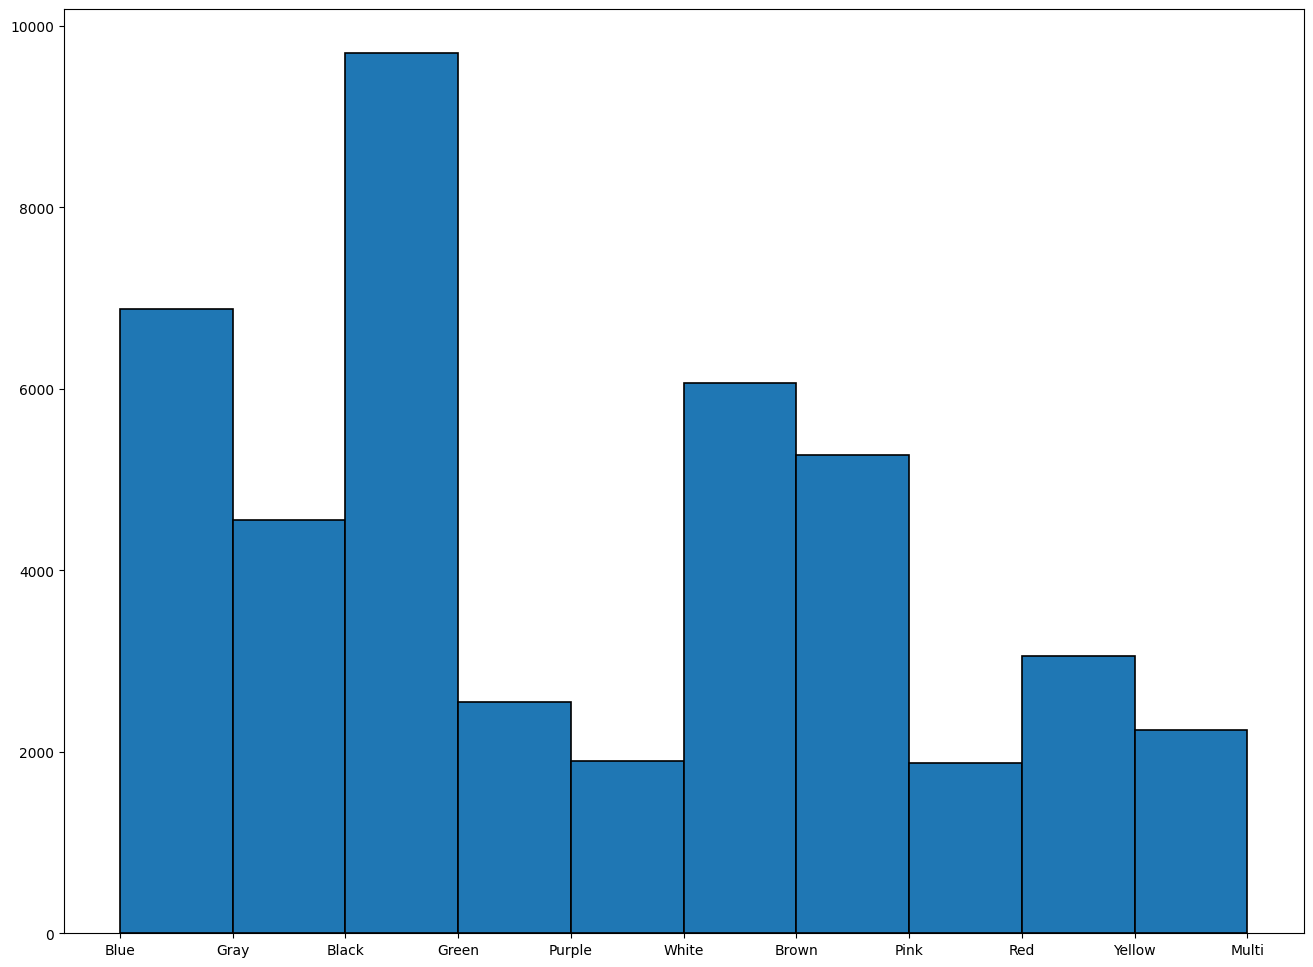

In [13]:
data_labels['baseColour'].hist(figsize=(16, 12), grid=False, edgecolor='black', linewidth=1.2)

In [14]:
labels_wo_col = list(labels)

In [15]:
labels_wo_col.remove('baseColour')

In [16]:
merged_df = data_labels.merge(data.drop(columns=['productDisplayName']), on='id', how='left', suffixes=('_replace', ''))
merged_df = merged_df.drop(columns=[f'{label}_replace' for label in labels])
merged_df['baseColour'] = merged_df['id'].map(new_colors)
data_labels = merged_df

# Neural Network Model

In [17]:
IMAGE_DATA_PATH = './image_data.npy'


def load_image(imagePath, image_size=IMAGE_SIZE):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_size[1], image_size[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image


if not os.path.exists(IMAGE_DATA_PATH):
    image_data = []
    for path in tqdm(data_labels['path']):
        image_data.append(load_image(path))
    image_data = np.array(image_data, dtype="float")
    np.save(IMAGE_DATA_PATH, image_data)
else:
    image_data = np.load(IMAGE_DATA_PATH)

In [18]:
y_binarized = []
LB = {}
for label in labels:
    LB[label] = LabelBinarizer()
    y_binarized.append(LB[label].fit_transform(np.array(data_labels[label])))

In [19]:
split = train_test_split(image_data, *y_binarized, test_size=0.3, random_state=SEED)

In [20]:
X_train, X_test = split[0], split[1]
X_val, X_test = train_test_split(X_test, test_size=(0.1 / 0.3), random_state=SEED)
y_train = {}
y_val = {}
y_test = {}
for i in range(2, len(split), 2):
    name = labels[i // 2 - 1]
    x, y = split[i], split[i + 1]
    y, z = train_test_split(y, test_size=(0.1 / 0.3), random_state=SEED)
    y_train[f'{name}_top'] = x
    y_val[f'{name}_top'] = y
    y_test[f'{name}_top'] = z

In [21]:
def build_resnet_based_model(labels, n_outs, concats, image_size=IMAGE_SIZE):
    def make_top(before_top, n_out, name):
        z = Dense(n_out)(before_top)
        z = Activation('softmax', name=f'{name}_top')(z)
        return z

    def make_branch(res_input, name, n_out):
        z = Dense(n_out*8, activation='relu')(res_input)
        z = Dense(n_out*4, activation='relu')(z)
        z = Dense(n_out*2, activation='relu')(z)
        z = Dense(n_out, activation='relu', name=f'{name}_out')(z)
        return z

    def make_concat(inp_main, inp_other, name_main, name_other):
        z = Concatenate(name=f'{name_main}_{name_other}_cat')([inp_main, inp_other])
        z = Dense(128, activation='relu')(z)
        z = Dense(128, activation='relu')(z)
        return z

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    base_model.trainable = False
    
    inputs = Input(shape=(*image_size, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)

    branches = {}
    for label in labels:
        branches[label] = make_branch(x, label, n_outs[label])

    befores = {}
    for main, other in concats:
        befores[main] = make_concat(
            branches[main], branches[other],
            main, other
        )

    outputs = []
    for label in labels:
        if label in befores:
            outputs.append(make_top(befores[label], n_outs[label], label))
        else:
            outputs.append(make_top(branches[label], n_outs[label], label))

    model = Model(inputs=inputs, outputs=outputs, name='ResnetBased')

    return model

In [22]:
# Dependencies
concats = [
    ('subCategory', 'masterCategory'),
    ('baseColour', 'masterCategory')
]

# Number of outputs
n_outs = {}
for label in labels:
    n_outs[label] = len(np.unique(data_labels[label]))

In [23]:
EPOCHS = 25
INIT_LR = 1e-4
BS = 64

In [24]:
def get_model(model_path, history_path):
    if os.path.exists(model_path) and os.path.exists(history_path):
        model = keras.models.load_model(model_path)
        frame = pd.read_csv(history_path)
        return model, frame
    
    model = build_resnet_based_model(labels, n_outs, concats)

    losses = {}
    for label in labels:
        losses[f'{label}_top'] = "categorical_crossentropy"

    metrics = {}
    for label in labels:
        metrics[f'{label}_top'] = "accuracy"

    # Construct class weights dictionary
    # class_weight_dict = {label: class_weights[label] for label in df.columns[1:]}

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=10000,
        decay_rate=0.99)

    opt = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt, loss=losses, metrics=metrics)
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(
            X_val, y_val
        ),
        epochs=EPOCHS,
        batch_size=BS,
        callbacks=[early_stopping]
    )
    
    model.save(model_path)
    frame = pd.DataFrame(history.history)
    frame.to_csv(history_path)
    
    return model, frame

model, frame = get_model('resnet_based.keras', 'history_resnet.csv')

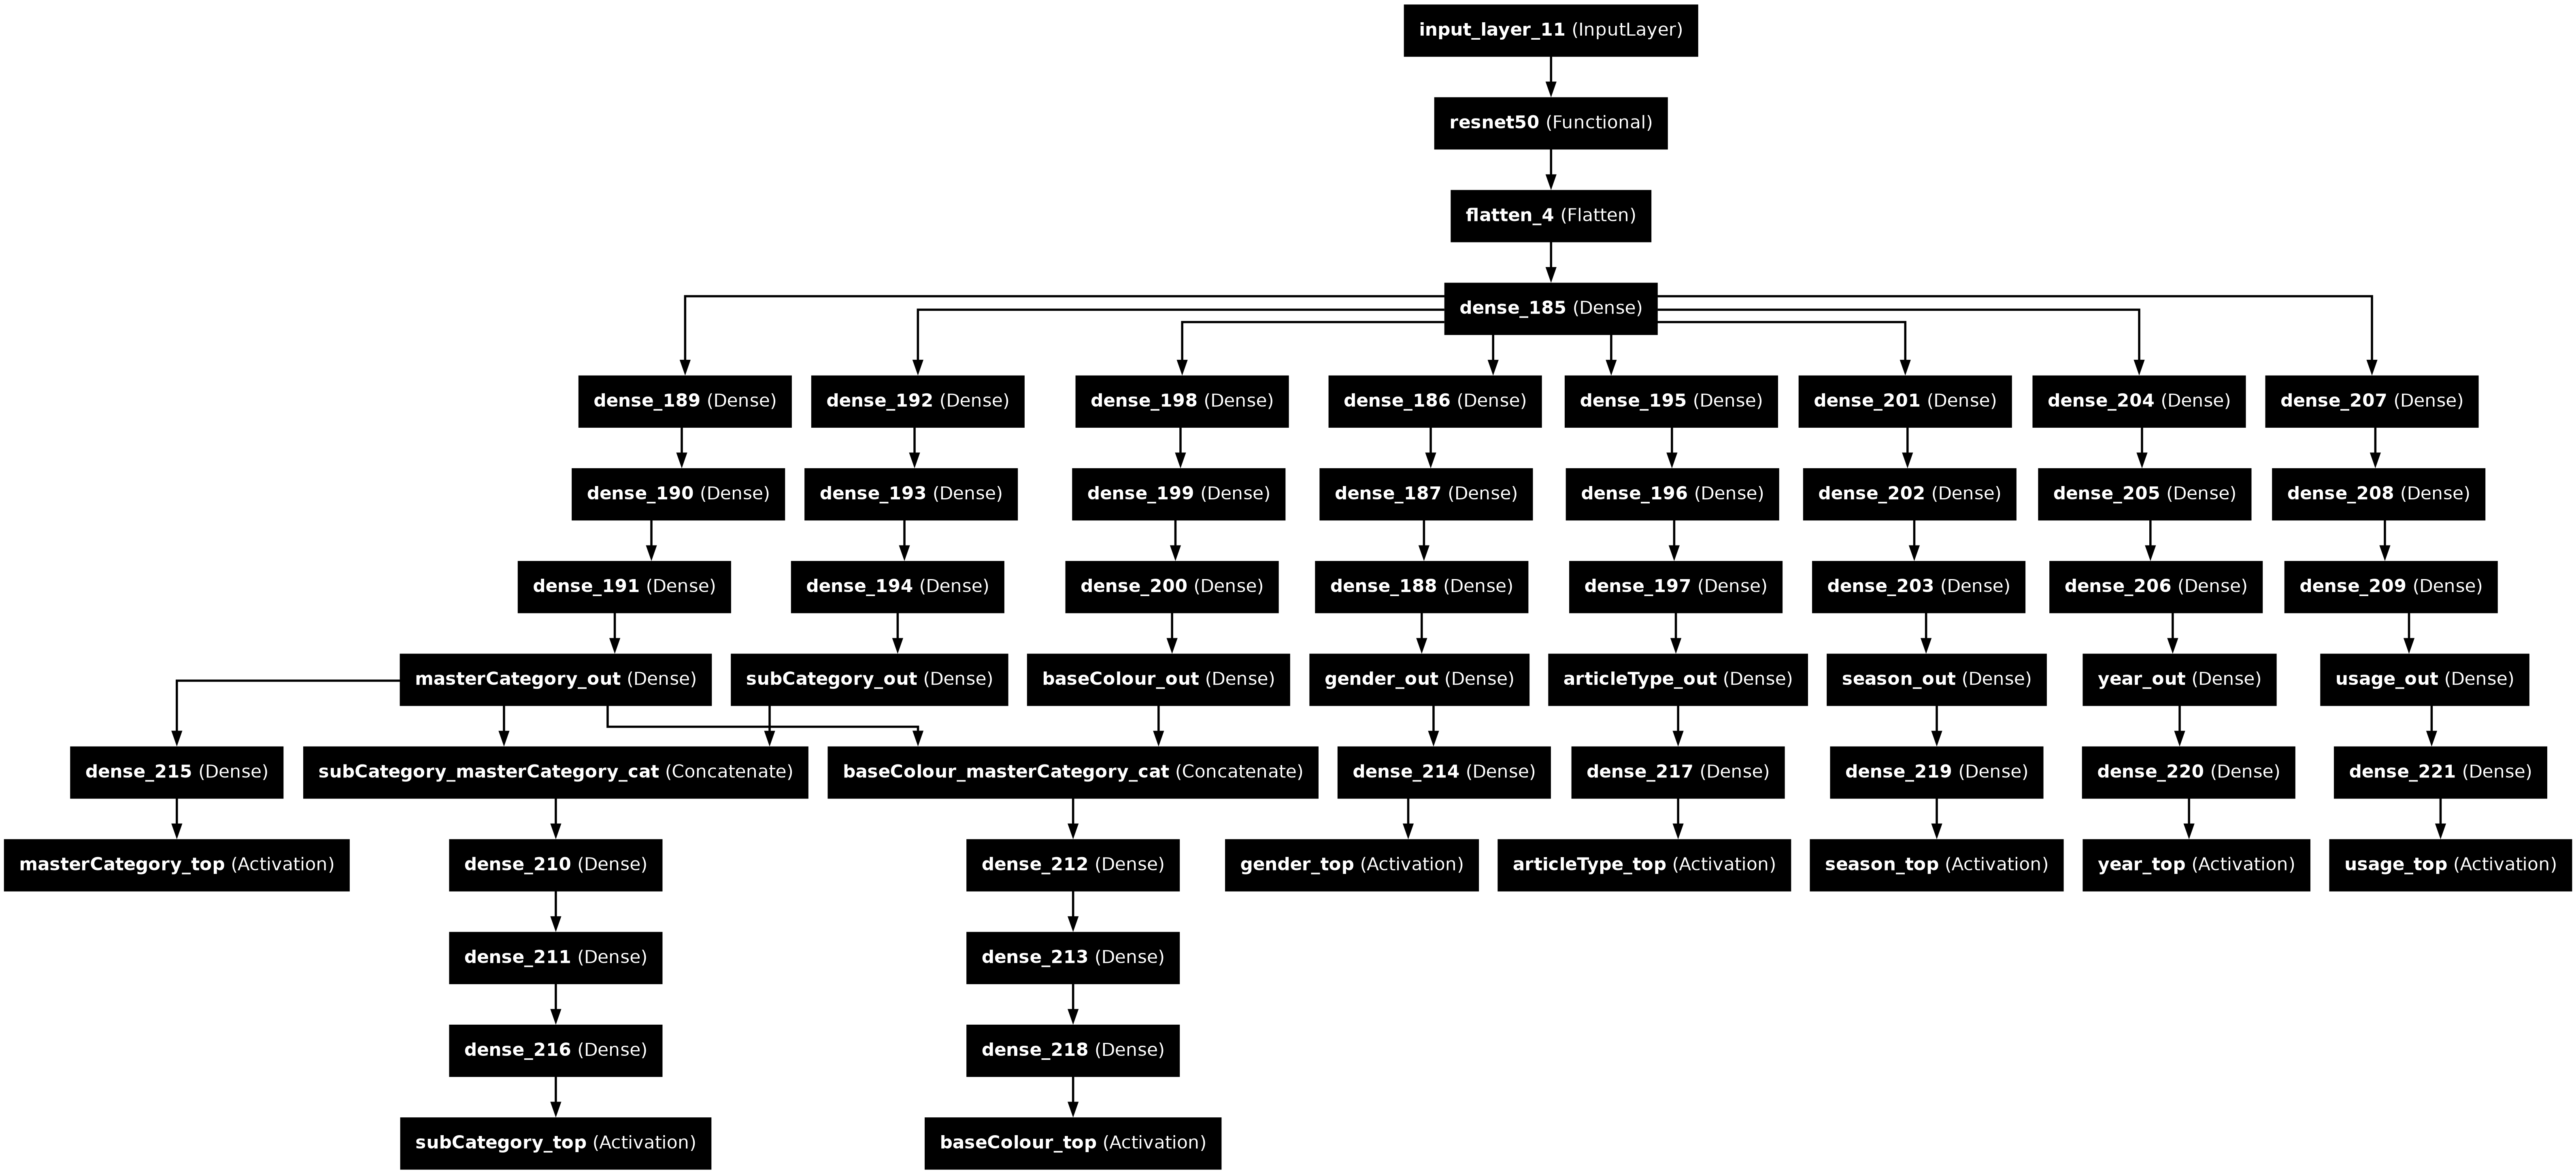

In [25]:
plot_model(model, show_layer_names=True)

In [26]:
model.summary()

Model: "ResnetBased"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 80, 60, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 3, 2,      │ 23,587,712 │ input_layer_11[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12288)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_185 (Dense)   │ (None, 1024)      │ 12,583,936 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_189 (Dense)   │ (None, 56)        │     57,400 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_192 (Dense)   │ (None, 360)       │    369,000 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_198 (Dense)   │ (None, 88)        │     90,200 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_190 (Dense)   │ (None, 28)        │      1,596 │ dense_189[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_193 (Dense)   │ (None, 180)       │     64,980 │ dense_192[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_199 (Dense)   │ (None, 44)        │      3,916 │ dense_198[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_191 (Dense)   │ (None, 14)        │        406 │ dense_190[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_194 (Dense)   │ (None, 90)        │     16,290 │ dense_193[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_200 (Dense)   │ (None, 22)        │        990 │ dense_199[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_186 (Dense)   │ (None, 40)        │     41,000 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masterCategory_out  │ (None, 7)         │        105 │ dense_191[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subCategory_out     │ (None, 45)        │      4,095 │ dense_194[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_195 (Dense)   │ (None, 1128)      │  1,156,200 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseColour_out      │ (None, 11)        │        253 │ dense_200[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_201 (Dense)   │ (None, 32)        │     32,800 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_204 (Dense)   │ (None, 104)       │    106,600 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_207 (Dense)   │ (None, 64)        │     65,600 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_187 (Dense)   │ (None, 20)        │        820 │ dense_186[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 70,126,473 (267.51 MB)

 Trainable params: 15,512,920 (59.18 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 31,025,841 (118.35 MB)

In [27]:
plts = ['loss', *[f'{label}_top_accuracy' for label in labels]]
plts = [(p, f'val_{p}') for p in plts]

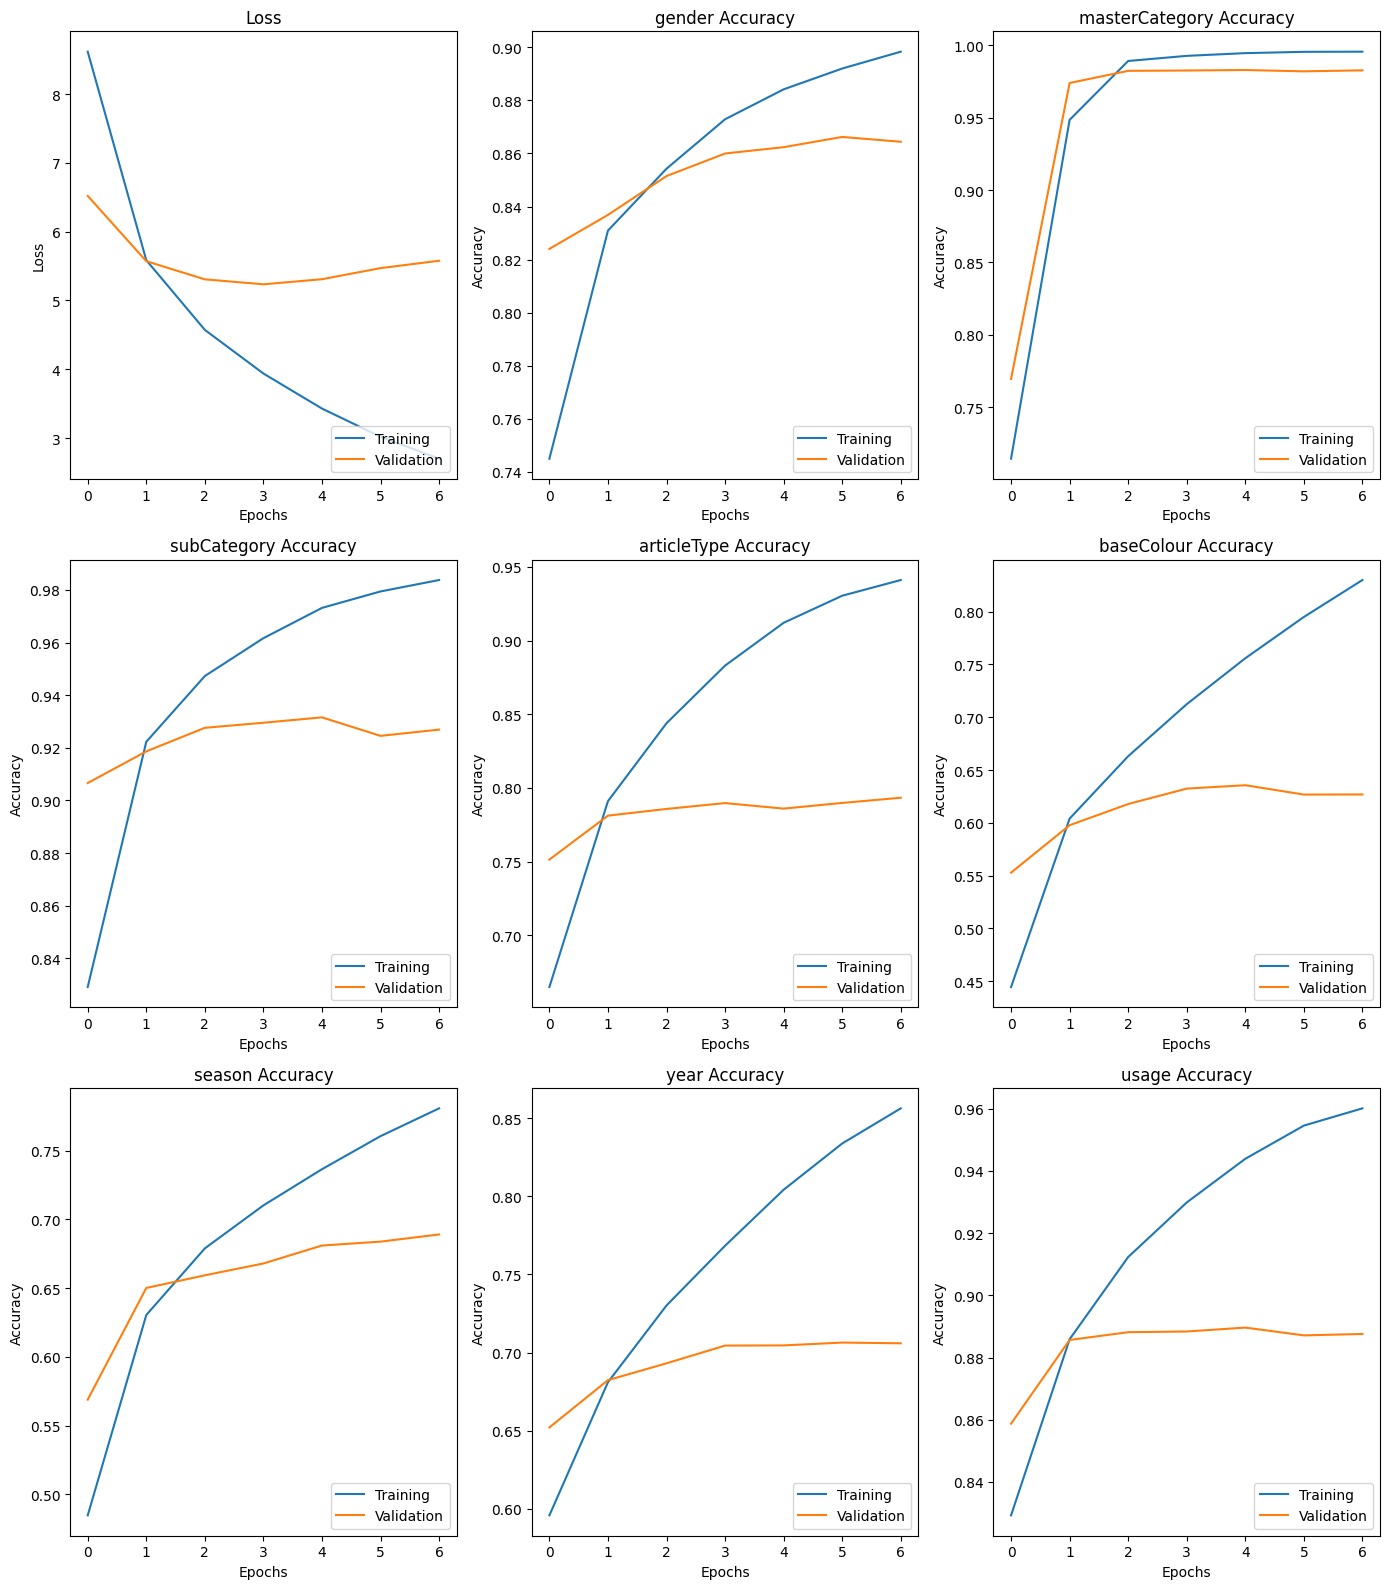

In [28]:
num_subplots = len(frame.columns) // 2
fig, axs = plt.subplots(num_subplots // 3, 3, figsize=(14, 16))

plts_v = {}

for i, (p, p_v) in enumerate(plts):
    name = p.replace('_top_accuracy', '')
    title = f'{name} Accuracy' if name != 'loss' else 'Loss'
    axs[i // 3, i % 3].set_title(title)
    values_train = frame[p]
    values_valid = frame[p_v]
    plts_v[name] = list(values_valid)[-1]
    axs[i // 3, i % 3].plot(values_train, label='Training')
    axs[i // 3, i % 3].plot(values_valid, label='Validation')
    axs[i // 3, i % 3].legend(loc='lower right')
    axs[i // 3, i % 3].set_xlabel('Epochs')
    axs[i // 3, i % 3].set_ylabel('Accuracy' if name != 'loss' else 'Loss')

plt.tight_layout()
plt.show()

In [29]:
res = model.evaluate(X_test, y_test, batch_size=BS, verbose=0)

I0000 00:00:1722718895.469631     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722718895.526826     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722718902.067186     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


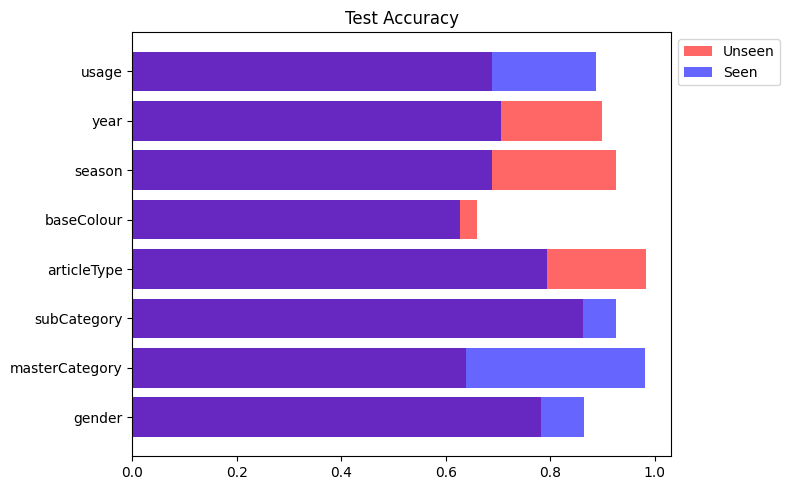

In [30]:
plt_x = labels
plt_y = res[1:]
plt_yv = [plts_v[l] for l in labels]
plt.figure(figsize=(8, 5))
plt.barh(plt_x, plt_y, color='red', alpha=0.6, label='Unseen')
plt.barh(plt_x, plt_yv, color='blue', alpha=0.6, label='Seen')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Test Accuracy')
plt.tight_layout()
plt.show()

In [31]:
def predict_labels(image_path):
    image = load_image(image_path)
    image = np.expand_dims(image, axis=0)
    output_probs = model.predict(image, verbose=0)
    predicted_classes = {}
    for i, probs in enumerate(output_probs):
        out = LB[labels[i]].inverse_transform(np.array(probs == probs.max(), dtype=np.int64))
        out = str(out[0])
        predicted_classes[labels[i]] = out
    return predicted_classes

def predict_and_show(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    l = predict_labels(imagePath)
    plt.title(' | '.join(list(l.values())))
    plt.axis('off')
    plt.imshow(image)

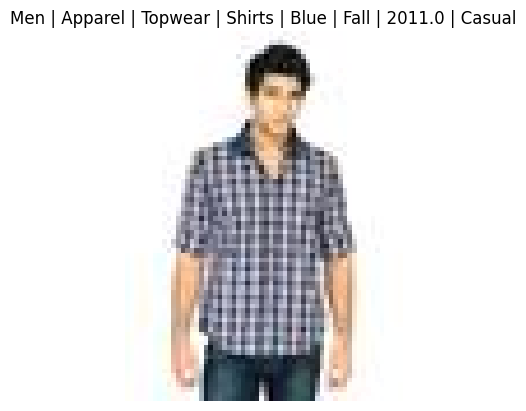

In [32]:
predict_and_show(data_labels['path'][0])

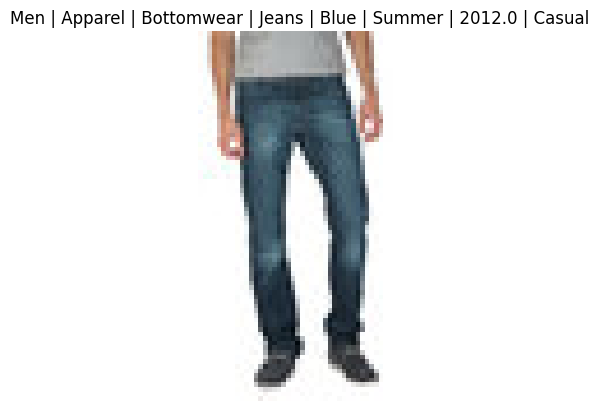

In [33]:
predict_and_show(data_labels['path'][1])

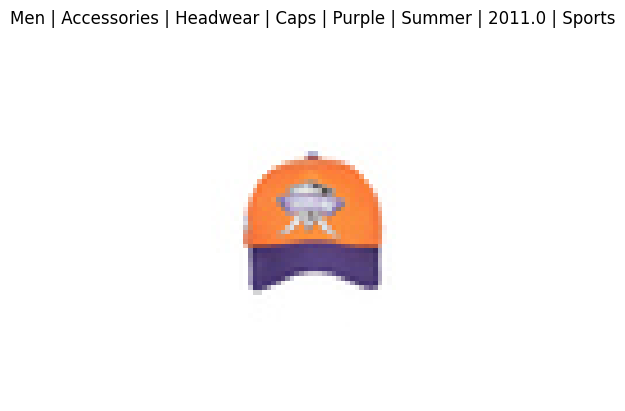

In [34]:
predict_and_show(data_labels['path'][1210])

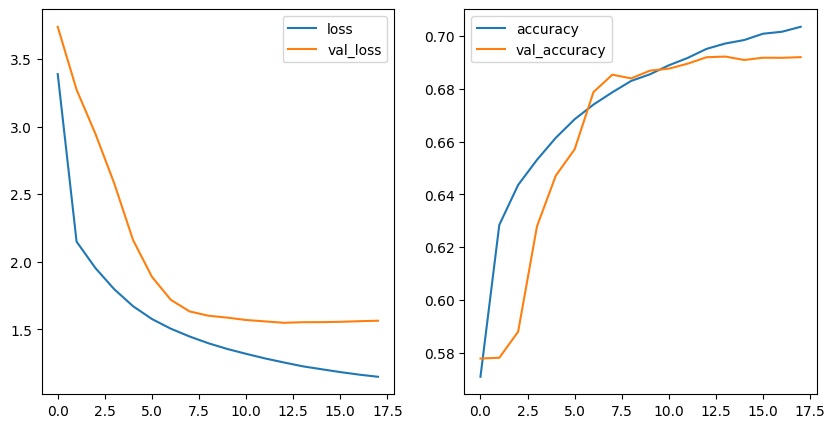

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
frame_caption.plot(y=['loss', 'val_loss'], ax=plt.gca())
plt.subplot(1, 2, 2)
frame_caption.plot(y=['accuracy', 'val_accuracy'], ax=plt.gca())
plt.show()